# NCAR Innovator Program Project
### Notebook by: Maria J. Molina (NCAR/University of Maryland) and Jessica Moulite (Howard University)

Here we compare the NOAA HOUSTON DUNN HELISTOP weather station temperature data with 2-m temperature data from ERA5. The objective of the comparison is to assess how representative state-of-the-art reanalysis is of local weather and trends, given its heavy use in climate assessment studies.

Importing packages

In [1]:
import datetime
import warnings
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

Functions

In [2]:
def cel_to_far(tmp):
    """
    Convert celsius to farenheit
    """
    newtmp = []
    for i in tmp:
        if i == 99.9:
            newtmp.append(np.nan)
        if i != 99.9:
            newtmp.append((i * (9/5)) + 32)
    return np.array(newtmp)


def cel_to_nan(tmp):
    """
    Change 9999 to np.nan
    """
    newtmp = []
    for i in tmp:
        if i == 99.9:
            newtmp.append(np.nan)
        if i != 99.9:
            newtmp.append(i)
    return np.array(newtmp)


def convert_to_datetime(time_value):
    """
    Convert to a datetime object to be able to compute time difference.
    """
    return datetime.datetime(
        pd.to_datetime(time_value).year,
        pd.to_datetime(time_value).month,
        pd.to_datetime(time_value).day,
        pd.to_datetime(time_value).hour,
        pd.to_datetime(time_value).minute,
        pd.to_datetime(time_value).second,
    )


def compute_time_difference(a, b):
    """
    Compute time difference between two times.
    """
    if a >= b:
        return convert_to_datetime(a) - convert_to_datetime(b)
    if b > a:
        return convert_to_datetime(b) - convert_to_datetime(a)


def extract_era5_time(t_daily, t_full):
    """
    Extract the era5 temperature corresponding time.
    """
    era5_time_array = []

    for i, j in zip(t_daily.time, t_daily):

        tmp = t_full.sel(
            time=slice(i, pd.to_datetime(i.values) + datetime.timedelta(hours=23)))

        era5_time_array.append(tmp.where(tmp == j, drop=True).time.values)

    return era5_time_array


def ends(df, x=5):
    """
    Viewing the beginnings and ends.
    """
    return pd.concat([df.head(x),df.tail(x)])

## Open ERA5 data (2008-present)

In [3]:
# open files
ds_ = xr.open_mfdataset(
    '/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/*/e5.oper.an.sfc.128_235_skt.ll025sc.*.nc'
)['SKT']

# time slice
ds_ = ds_.sel(time=slice('2008-10-23T00:00:00', '2022-08-01T23:00:00'))

In [4]:
ds_

<xarray.DataArray 'SKT' (time: 120744, latitude: 721, longitude: 1440)>
dask.array<getitem, shape=(120744, 721, 1440), dtype=float32, chunksize=(744, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 2008-10-23 ... 2022-08-01T23:00:00
Attributes: (12/14)
    long_name:                                          Skin temperature
    short_name:                                         skt
    units:                                              K
    original_format:                                    WMO GRIB 1 with ECMWF...
    ecmwf_local_table:                                  128
    ecmwf_parameter:                                    235
    ...                                                 ...
    grid_specification:                                 0.25 degree x 0.25 de...
    rda_dataset:                                        ds633.0
    rda_dataset_url:                                    https:/rda.ucar.edu/d...
    rda_dataset_doi:                                    DOI: 10.5065/BH6N-5N20
    rda_dataset_group:                                  ERA5 atmospheric surf...
    QuantizeGranularBitGroomNumberOfSignificantDigits:  7

## Open NOAA HOUSTON DUNN HELISTOP station data

In [5]:
HOU_temp = pd.read_csv('/glade/scratch/molina/3043194.csv', low_memory=False)

In [6]:
HOU_temp = HOU_temp.iloc[25:326788]

In [7]:
ends(HOU_temp, 2)

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,SOURCE,REPORT_TYPE,CALL_SIGN,QUALITY_CONTROL,...,MW1,OC1,QUALITY_CONTROL.1,REM,REPORT_TYPE.1,SLP,SOURCE.1,TMP,VIS,WND
25,72059400188,"HOUSTON DUNN HELISTOP, TX US",29.717,-95.383,69.2,2008-10-23T00:00:00,4,FM-15,KMCJ,V020,...,NaN,"0103,1",V020,MET086METAR KMCJ 222355Z AUTO 33009G20KT 5SM F...,FM-15,"99999,9",4,"+0230,1","008046,1,N,1","330,1,N,0046,1"
26,72059400188,"HOUSTON DUNN HELISTOP, TX US",29.717,-95.383,69.2,2008-10-23T00:15:00,4,AUTO,KMCJ,V020,...,NaN,"0118,1",V020,MET089METAR KMCJ 230015Z AUTO 03006G23KT 040V0...,AUTO,"99999,9",4,"+0200,1","000805,1,N,1","030,1,N,0031,1"
326786,72059400188,"HOUSTON DUNN HELISTOP, TX US",29.717,-95.383,69.2,2022-08-01T23:35:00,6,FM-15,KMCJ,V020,...,NaN,NaN,V020,MET07608/01/22 17:35:02 METAR KMCJ 012335Z 120...,FM-15,"99999,9",6,"+0290,5","016093,5,N,5","120,5,N,0026,5"
326787,72059400188,"HOUSTON DUNN HELISTOP, TX US",29.717,-95.383,69.2,2022-08-01T23:55:00,6,FM-15,KMCJ,V020,...,NaN,NaN,V020,MET07608/01/22 17:55:02 METAR KMCJ 012355Z 140...,FM-15,"99999,9",6,"+0300,C","016093,5,N,5","140,5,N,0026,5"


In [8]:
time_date = []
temperature_C = []

for j, i in zip(HOU_temp['DATE'].values, HOU_temp['TMP'].values.astype(str)):

    time_date.append(j)

    # convert the string format to decimal format (originally in METAR code)
    temperature_C.append(
        float(i[0]+i.split(',')[0][2:-1]+'.'+i.split(',')[0][-1]))

time_date = np.array(time_date)
temperature_C = np.array(temperature_C)

temperature_F = cel_to_far(temperature_C)
temperature_C = cel_to_nan(temperature_C)

In [9]:
# making into dataframe for easier manipulation

# initialize data of lists.
data = {'Datetime': pd.to_datetime(time_date),
        'Temperature_C': temperature_C,
        'Temperature_F': temperature_F,
        'Latitude': HOU_temp['LATITUDE'],
        'Longitude': HOU_temp['LONGITUDE'],
       }

# Create DataFrame and quality control
df = pd.DataFrame(data)
#df = df.dropna()  # drop any nan values
df = df.drop_duplicates(keep='first')
# drop any duplicate rows
df = df[~df['Datetime'].duplicated()].drop_duplicates()

## Select temperatures from ERA5 using NOAA metadata (lat, lon, and hour)

In [10]:
with warnings.catch_warnings():

    warnings.simplefilter('ignore')

    tmp = ds_.sel(
        longitude=(df['Longitude'] % 360).unique()[-1], 
        latitude=df['Latitude'].unique()[-1], 
        method='nearest')

In [11]:
tmp

<xarray.DataArray 'SKT' (time: 120744)>
dask.array<getitem, shape=(120744,), dtype=float32, chunksize=(744,), chunktype=numpy.ndarray>
Coordinates:
    latitude   float64 29.75
    longitude  float64 264.5
  * time       (time) datetime64[ns] 2008-10-23 ... 2022-08-01T23:00:00
Attributes: (12/14)
    long_name:                                          Skin temperature
    short_name:                                         skt
    units:                                              K
    original_format:                                    WMO GRIB 1 with ECMWF...
    ecmwf_local_table:                                  128
    ecmwf_parameter:                                    235
    ...                                                 ...
    grid_specification:                                 0.25 degree x 0.25 de...
    rda_dataset:                                        ds633.0
    rda_dataset_url:                                    https:/rda.ucar.edu/d...
    rda_dataset_doi:                                    DOI: 10.5065/BH6N-5N20
    rda_dataset_group:                                  ERA5 atmospheric surf...
    QuantizeGranularBitGroomNumberOfSignificantDigits:  7

In [12]:
print('ERA5 coordinates:', tmp.latitude.values, tmp.longitude.values-360)
print('NOAA coordinates:', df['Latitude'].unique(), df['Longitude'].unique())

ERA5 coordinates: 29.75 -95.5
NOAA coordinates: [29.717] [-95.383]


In [13]:
ERA5_temperatures_C = (tmp - 273.15).values

ERA5_date = tmp.coords['time'].values

ERA5_temperatures_F = cel_to_far(ERA5_temperatures_C)

In [14]:
# initialize data of lists.
data = {'Datetime': pd.to_datetime(ERA5_date),
        'Temperature_C': ERA5_temperatures_C,
        'Temperature_F': ERA5_temperatures_F,
       }

df_era5 = pd.DataFrame(data)

### clean up dates prior to computation of metrics

In [23]:
df.isnull().sum()

Datetime            0
Temperature_C    1795
Temperature_F    1795
Latitude            0
Longitude           0
dtype: int64

In [16]:
df_era5.isnull().sum()

Datetime         0
Temperature_C    0
Temperature_F    0
dtype: int64

In [17]:
# confirm start and end dates are the same
assert df['Datetime'].iloc[0].date() == df_era5['Datetime'].iloc[0].date()
assert df['Datetime'].iloc[-1].date() == df_era5['Datetime'].iloc[-1].date()

## Create new variables

### Daily max and min temperatures

In [24]:
# Daily NOAA temperature maximum
tmax_NOAA_daily = df.set_index('Datetime').resample('1D').max()

In [25]:
tmax_NOAA_daily.isnull().sum()

Temperature_C    224
Temperature_F    224
Latitude         223
Longitude        223
dtype: int64

In [26]:
# Daily ERA5 temperature maximum
tmax_ERA5_daily = df_era5.set_index('Datetime').resample('1D').max()

In [27]:
tmax_ERA5_daily.isnull().sum()

Temperature_C    0
Temperature_F    0
dtype: int64

In [28]:
# Daily NOAA temperature minimum
tmin_NOAA_daily = df.set_index('Datetime').resample('1D').min()

In [29]:
tmin_NOAA_daily.isnull().sum()

Temperature_C    224
Temperature_F    224
Latitude         223
Longitude        223
dtype: int64

In [30]:
# Daily ERA5 temperature minimum
tmin_ERA5_daily = df_era5.set_index('Datetime').resample('1D').min()

In [31]:
tmin_ERA5_daily.isnull().sum()

Temperature_C    0
Temperature_F    0
dtype: int64

In [32]:
# double check array lengths
assert len(tmax_NOAA_daily) == len(tmax_ERA5_daily), 'Arrays not same length'
assert len(tmin_NOAA_daily) == len(tmin_ERA5_daily), 'Arrays not same length'

### Time of daily max and min temperatures

In [33]:
# corresponding date/time for NOAA daily temperature maximum
tmax_NOAA_daily_datetime = df.set_index('Datetime').resample('1D').agg(
    lambda x: np.nan if x.count() == 0 else x.idxmax())['Temperature_C']

In [34]:
tmax_NOAA_daily_datetime.isnull().sum()

224

In [35]:
# corresponding date/time for NOAA daily temperature minimum
tmin_NOAA_daily_datetime = df.set_index('Datetime').resample('1D').agg(
    lambda x: np.nan if x.count() == 0 else x.idxmin())['Temperature_C']

In [36]:
tmin_NOAA_daily_datetime.isnull().sum()

224

In [37]:
# corresponding date/time for ERA5 daily temperature maximum
tmax_ERA5_daily_datetime = df_era5.set_index('Datetime').resample('1D').agg(
    lambda x: np.nan if x.count() == 0 else x.idxmax())['Temperature_C']

In [38]:
tmax_ERA5_daily_datetime.isnull().sum()

0

In [39]:
# corresponding date/time for ERA5 daily temperature minimum
tmin_ERA5_daily_datetime = df_era5.set_index('Datetime').resample('1D').agg(
    lambda x: np.nan if x.count() == 0 else x.idxmin())['Temperature_C']

In [40]:
tmin_ERA5_daily_datetime.isnull().sum()

0

In [41]:
# double check array lengths
assert len(tmax_NOAA_daily_datetime) == len(tmax_ERA5_daily_datetime), 'Arrays not same length'
assert len(tmin_NOAA_daily_datetime) == len(tmin_ERA5_daily_datetime), 'Arrays not same length'

### Corresponding temperatures at the time of the max/min of other product

In [42]:
# the NOAA temperature during the (i.e., same time as the
# daily ERA5 maximum temperature)

NOAA_temp_during_ERA5_tmax_C = []
NOAA_temp_during_ERA5_tmax_F = []

for i in tmax_ERA5_daily_datetime.values:

    with warnings.catch_warnings():
        
        warnings.simplefilter('ignore')
    
        NOAA_temp_during_ERA5_tmax_C.append(
            df.iloc[df.set_index('Datetime').index.get_loc(
                i, method='nearest')]['Temperature_C'])

        NOAA_temp_during_ERA5_tmax_F.append(
            df.iloc[df.set_index('Datetime').index.get_loc(
                i, method='nearest')]['Temperature_F'])

NOAA_temp_during_ERA5_tmax_C = np.array(NOAA_temp_during_ERA5_tmax_C)
NOAA_temp_during_ERA5_tmax_F = np.array(NOAA_temp_during_ERA5_tmax_F)

In [43]:
print(np.any(np.isnan(NOAA_temp_during_ERA5_tmax_C)))
print(np.any(np.isnan(NOAA_temp_during_ERA5_tmax_F)))

True
True


In [44]:
# the NOAA temperature during the (i.e., same time as the
# daily ERA5 minimum temperature)

NOAA_temp_during_ERA5_tmin_C = []
NOAA_temp_during_ERA5_tmin_F = []

for i in tmin_ERA5_daily_datetime.values:

    with warnings.catch_warnings():
        
        warnings.simplefilter('ignore')
        
        NOAA_temp_during_ERA5_tmin_C.append(
            df.iloc[df.set_index('Datetime').index.get_loc(i, method='nearest')]['Temperature_C'])

        NOAA_temp_during_ERA5_tmin_F.append(
            df.iloc[df.set_index('Datetime').index.get_loc(i, method='nearest')]['Temperature_F'])

NOAA_temp_during_ERA5_tmin_C = np.array(NOAA_temp_during_ERA5_tmin_C)
NOAA_temp_during_ERA5_tmin_F = np.array(NOAA_temp_during_ERA5_tmin_F)

In [45]:
print(np.any(np.isnan(NOAA_temp_during_ERA5_tmin_C)))
print(np.any(np.isnan(NOAA_temp_during_ERA5_tmin_F)))

True
True


In [46]:
# the ERA5 temperature during the (i.e., same time as the
# daily NOAA maximum temperature)

ERA5_temp_during_NOAA_tmax_C = []
ERA5_temp_during_NOAA_tmax_F = []

for i in tmax_NOAA_daily_datetime.values:

    with warnings.catch_warnings():
        
        warnings.simplefilter('ignore')
        
        try:
    
            ERA5_temp_during_NOAA_tmax_C.append(
                df_era5.iloc[df_era5.set_index('Datetime').index.get_loc(
                    i, method='nearest')]['Temperature_C'])

            ERA5_temp_during_NOAA_tmax_F.append(
                df_era5.iloc[df_era5.set_index('Datetime').index.get_loc(
                    i, method='nearest')]['Temperature_F'])
        
        except KeyError:
            
            ERA5_temp_during_NOAA_tmax_C.append(np.nan)
            ERA5_temp_during_NOAA_tmax_F.append(np.nan)

ERA5_temp_during_NOAA_tmax_C = np.array(ERA5_temp_during_NOAA_tmax_C)
ERA5_temp_during_NOAA_tmax_F = np.array(ERA5_temp_during_NOAA_tmax_F)

In [47]:
print(np.any(np.isnan(ERA5_temp_during_NOAA_tmax_C)))
print(np.any(np.isnan(ERA5_temp_during_NOAA_tmax_F)))

True
True


In [48]:
# the ERA5 temperature during the (i.e., same time as the
# daily NOAA minimum temperature)

ERA5_temp_during_NOAA_tmin_C = []
ERA5_temp_during_NOAA_tmin_F = []

for i in tmin_NOAA_daily_datetime.values:

    with warnings.catch_warnings():
        
        warnings.simplefilter('ignore')
    
        try:
            
            ERA5_temp_during_NOAA_tmin_C.append(
                df_era5.iloc[df_era5.set_index('Datetime').index.get_loc(
                    i, method='nearest')]['Temperature_C'])

            ERA5_temp_during_NOAA_tmin_F.append(
                df_era5.iloc[df_era5.set_index('Datetime').index.get_loc(
                    i, method='nearest')]['Temperature_F'])
            
        except KeyError:
            
            ERA5_temp_during_NOAA_tmin_C.append(np.nan)
            ERA5_temp_during_NOAA_tmin_F.append(np.nan)

ERA5_temp_during_NOAA_tmin_C = np.array(ERA5_temp_during_NOAA_tmin_C)
ERA5_temp_during_NOAA_tmin_F = np.array(ERA5_temp_during_NOAA_tmin_F)

In [49]:
print(np.any(np.isnan(ERA5_temp_during_NOAA_tmin_C)))
print(np.any(np.isnan(ERA5_temp_during_NOAA_tmin_F)))

True
True


In [50]:
# double check array lengths
assert len(NOAA_temp_during_ERA5_tmax_C) == len(ERA5_temp_during_NOAA_tmax_C), 'Arrays not same length'
assert len(NOAA_temp_during_ERA5_tmin_C) == len(ERA5_temp_during_NOAA_tmin_C), 'Arrays not same length'
assert len(NOAA_temp_during_ERA5_tmax_F) == len(ERA5_temp_during_NOAA_tmax_F), 'Arrays not same length'
assert len(NOAA_temp_during_ERA5_tmin_F) == len(ERA5_temp_during_NOAA_tmin_F), 'Arrays not same length'

### differences (temperature)

In [51]:
# difference between NOAA temperature maximum and
# the ERA5 corresponding temperature at that time (C)
tmax_daily_difference_C = tmax_NOAA_daily['Temperature_C'] - ERA5_temp_during_NOAA_tmax_C

In [52]:
# difference between NOAA temperature maximum and
# the ERA5 corresponding temperature at that time (F)
tmax_daily_difference_F = tmax_NOAA_daily['Temperature_F'] - ERA5_temp_during_NOAA_tmax_F

In [53]:
# difference between NOAA temperature minimum and
# the ERA5 corresponding temperature at that time (C)
tmin_daily_difference_C = tmin_NOAA_daily['Temperature_C'] - ERA5_temp_during_NOAA_tmin_C

In [54]:
# difference between NOAA temperature minimum and
# the ERA5 corresponding temperature at that time (C)
tmin_daily_difference_F = tmin_NOAA_daily['Temperature_F'] - ERA5_temp_during_NOAA_tmin_F

### compute time differences

In [55]:
# absolute time difference between daily maximum temperature (ERA5 and NOAA)
tmax_diff = []
for i, j in zip(pd.to_datetime(tmax_NOAA_daily_datetime), tmax_ERA5_daily_datetime):
    tmax_diff.append(compute_time_difference(i, j))
tmax_diff = np.array(tmax_diff)

In [56]:
# absolute time difference between daily minimum temperature (ERA5 and NOAA)
tmin_diff = []
for i, j in zip(pd.to_datetime(tmin_NOAA_daily_datetime), tmin_ERA5_daily_datetime):
    tmin_diff.append(compute_time_difference(i, j))
tmin_diff = np.array(tmin_diff)

### create single csv file

In [57]:
data = {

    'NOAA_HOU_Temperature_Daily_Max (C)': tmax_NOAA_daily['Temperature_C'],
    'NOAA_HOU_Temperature_Daily_Max (F)': tmax_NOAA_daily['Temperature_F'],
    'NOAA_HOU_Temperature_Daily_Max_Datetime': tmax_NOAA_daily_datetime,

    'NOAA_HOU_Temperature_Daily_Min (C)': tmin_NOAA_daily['Temperature_C'],
    'NOAA_HOU_Temperature_Daily_Min (F)': tmin_NOAA_daily['Temperature_F'],
    'NOAA_HOU_Temperature_Daily_Min_Datetime': tmin_NOAA_daily_datetime,

    'ERA5_Temperature_Daily_Max (C)': tmax_ERA5_daily['Temperature_C'],
    'ERA5_Temperature_Daily_Max (F)': tmax_ERA5_daily['Temperature_F'],
    'ERA5_Temperature_Daily_Max_Datetime': tmax_ERA5_daily_datetime,

    'ERA5_Temperature_Daily_Min (C)': tmin_ERA5_daily['Temperature_C'],
    'ERA5_Temperature_Daily_Min (F)': tmin_ERA5_daily['Temperature_F'],
    'ERA5_Temperature_Daily_Min_Datetime': tmin_ERA5_daily_datetime,


    'ERA5_Corresponding_Temperature_During_NOAA_HOU_Daily_Max (C)': ERA5_temp_during_NOAA_tmax_C,
    'ERA5_Corresponding_Temperature_During_NOAA_HOU_Daily_Max (F)': ERA5_temp_during_NOAA_tmax_F,

    'ERA5_Corresponding_Temperature_During_NOAA_HOU_Daily_Min (C)': ERA5_temp_during_NOAA_tmin_C,
    'ERA5_Corresponding_Temperature_During_NOAA_HOU_Daily_Min (F)': ERA5_temp_during_NOAA_tmin_F,

    'NOAA_HOU_Corresponding_Temperature_During_ERA5_Daily_Max (C)': NOAA_temp_during_ERA5_tmax_C,
    'NOAA_HOU_Corresponding_Temperature_During_ERA5_Daily_Max (F)': NOAA_temp_during_ERA5_tmax_F,

    'NOAA_HOU_Corresponding_Temperature_During_ERA5_Daily_Min (C)': NOAA_temp_during_ERA5_tmin_C,
    'NOAA_HOU_Corresponding_Temperature_During_ERA5_Daily_Min (F)': NOAA_temp_during_ERA5_tmin_F,


    'Daily_Temperature_Max_Difference (C)': tmax_daily_difference_C.values,
    'Daily_Temperature_Max_Difference (F)': tmax_daily_difference_F.values,

    'Daily_Temperature_Min_Difference (C)': tmin_daily_difference_C.values,
    'Daily_Temperature_Min_Difference (F)': tmin_daily_difference_F.values,

    'Absolute_time_difference_tmax_ERA5_NOAA_HOU (day H:M:S)': tmax_diff,
    'Absolute_time_difference_tmin_ERA5_NOAA_HOU (day H:M:S)': tmin_diff,

       }

In [58]:
df_FINAL = pd.DataFrame(data)

In [59]:
ends(df_FINAL, 2)

,NOAA_HOU_Temperature_Daily_Max (C),NOAA_HOU_Temperature_Daily_Max (F),NOAA_HOU_Temperature_Daily_Max_Datetime,NOAA_HOU_Temperature_Daily_Min (C),NOAA_HOU_Temperature_Daily_Min (F),NOAA_HOU_Temperature_Daily_Min_Datetime,ERA5_Temperature_Daily_Max (C),ERA5_Temperature_Daily_Max (F),ERA5_Temperature_Daily_Max_Datetime,ERA5_Temperature_Daily_Min (C),...,NOAA_HOU_Corresponding_Temperature_During_ERA5_Daily_Max (C),NOAA_HOU_Corresponding_Temperature_During_ERA5_Daily_Max (F),NOAA_HOU_Corresponding_Temperature_During_ERA5_Daily_Min (C),NOAA_HOU_Corresponding_Temperature_During_ERA5_Daily_Min (F),Daily_Temperature_Max_Difference (C),Daily_Temperature_Max_Difference (F),Daily_Temperature_Min_Difference (C),Daily_Temperature_Min_Difference (F),Absolute_time_difference_tmax_ERA5_NOAA_HOU (day H:M:S),Absolute_time_difference_tmin_ERA5_NOAA_HOU (day H:M:S)
Datetime,,,,,,,,,,,,,,,,,,,,,
2008-10-23,23.0,73.4,2008-10-23 00:00:00,13.0,55.4,2008-10-23 11:35:00,22.168915,71.904047,2008-10-23 20:00:00,13.051971,...,19.0,66.2,13.0,55.4,1.480865,2.665558,-0.979004,-1.762207,0 days 20:00:00,0 days 01:25:00
2008-10-24,25.0,77.0,2008-10-24 20:00:00,12.0,53.6,2008-10-24 08:15:00,27.241180,81.034125,2008-10-24 19:00:00,5.781891,...,24.0,75.2,12.0,53.6,-1.718414,-3.093146,4.166168,7.499103,0 days 01:00:00,0 days 03:45:00
2022-07-31,34.0,93.2,2022-07-31 17:35:00,26.0,78.8,2022-07-31 10:55:00,41.234192,106.221545,2022-07-31 20:00:00,24.958099,...,33.0,91.4,26.0,78.8,-7.157196,-12.882953,1.041901,1.875421,0 days 02:25:00,0 days 00:05:00
2022-08-01,33.0,91.4,2022-08-01 20:35:00,26.0,78.8,2022-08-01 08:55:00,41.694733,107.050519,2022-08-01 19:00:00,25.854889,...,32.0,89.6,26.0,78.8,-7.399689,-13.319440,0.145111,0.261200,0 days 01:35:00,0 days 00:05:00


### data visualizations

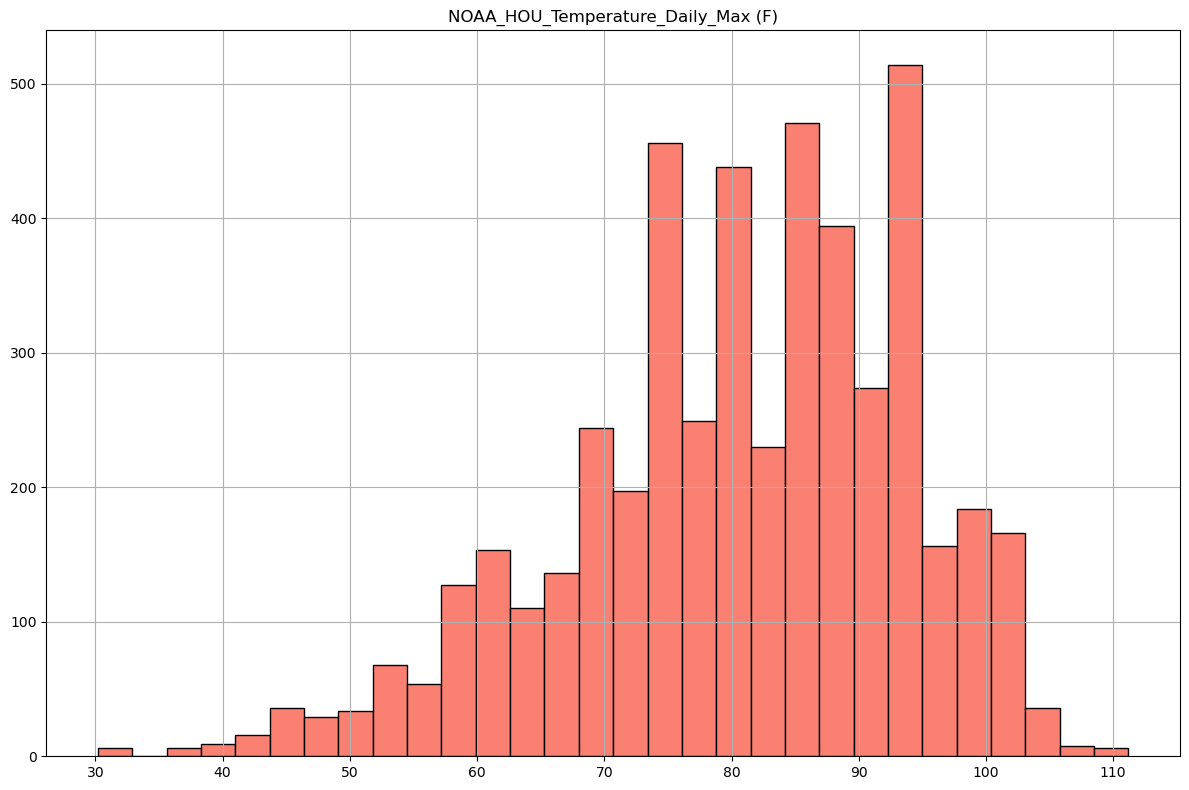

In [60]:
fig = df_FINAL.hist(
    'NOAA_HOU_Temperature_Daily_Max (F)', edgecolor='k', facecolor='salmon', bins=30, figsize=(12,8))
plt.tight_layout()
plt.show()

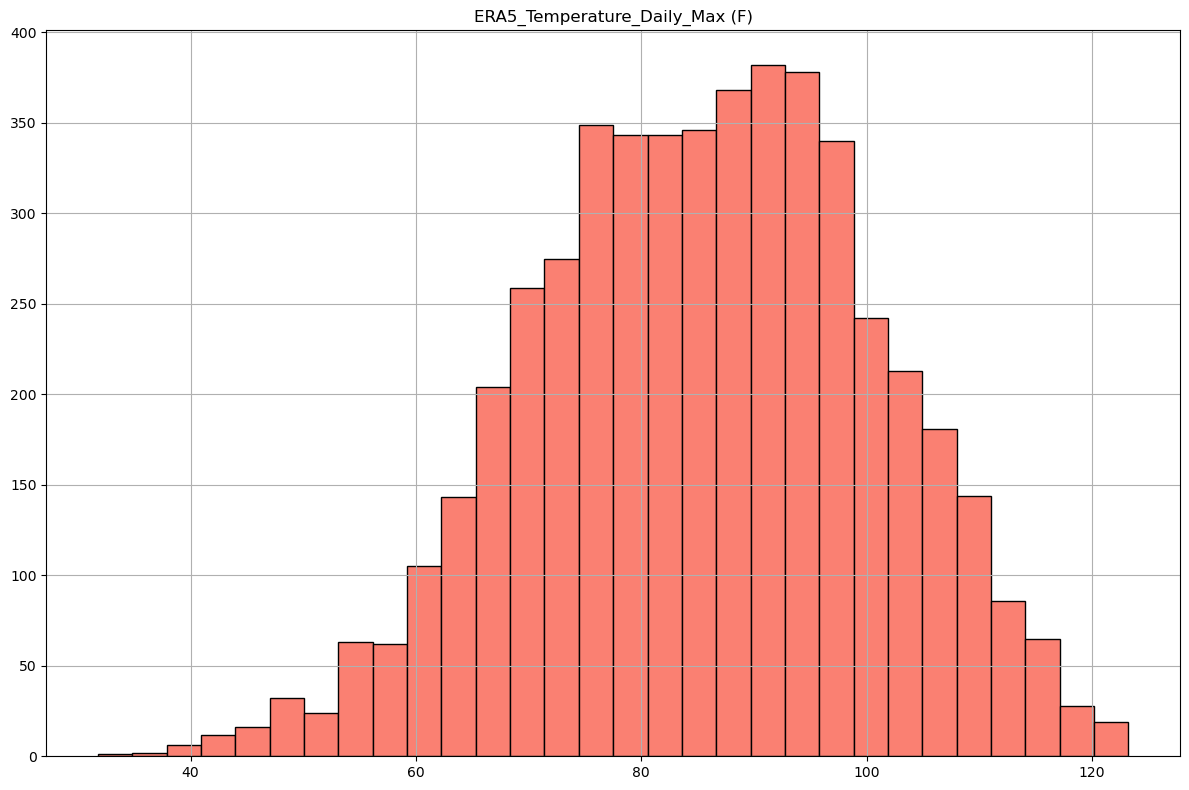

In [61]:
fig = df_FINAL.hist(
    'ERA5_Temperature_Daily_Max (F)', edgecolor='k', facecolor='salmon', bins=30, figsize=(12,8))
plt.tight_layout()
plt.show()

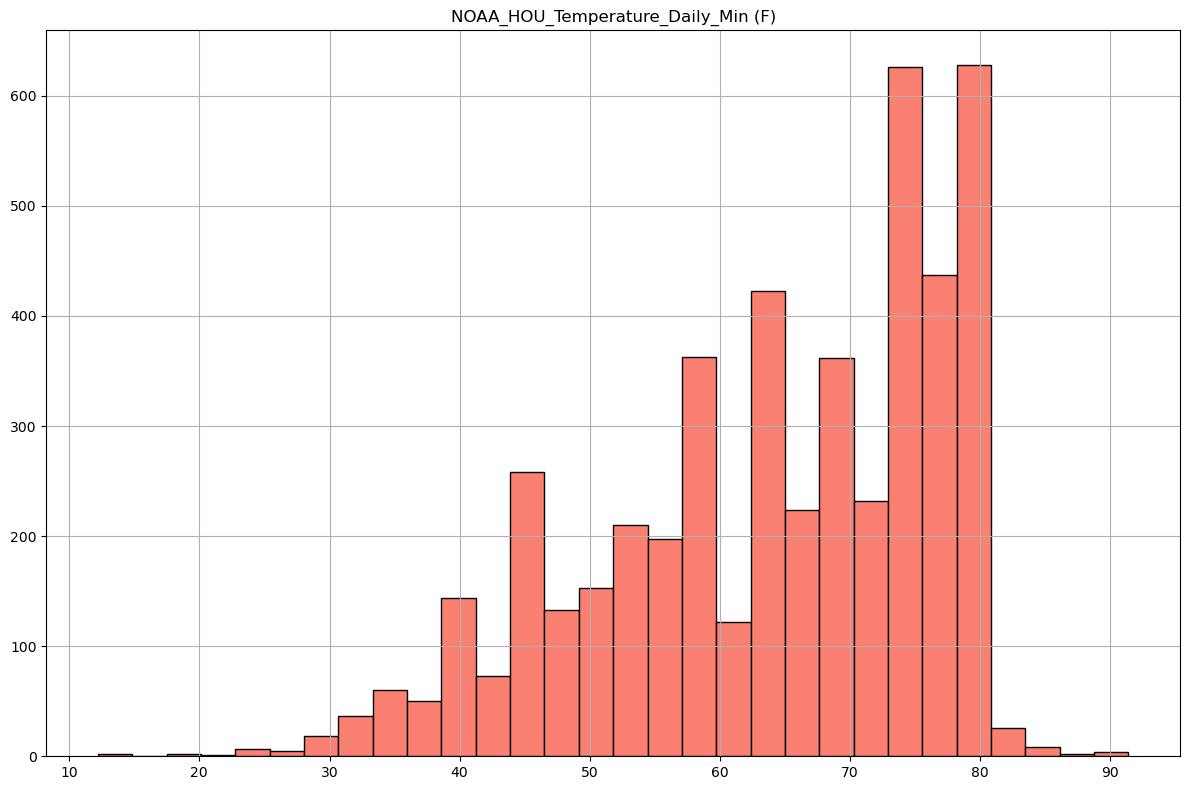

In [62]:
fig = df_FINAL.hist(
    'NOAA_HOU_Temperature_Daily_Min (F)', edgecolor='k', facecolor='salmon', bins=30, figsize=(12,8))
plt.tight_layout()
plt.show()

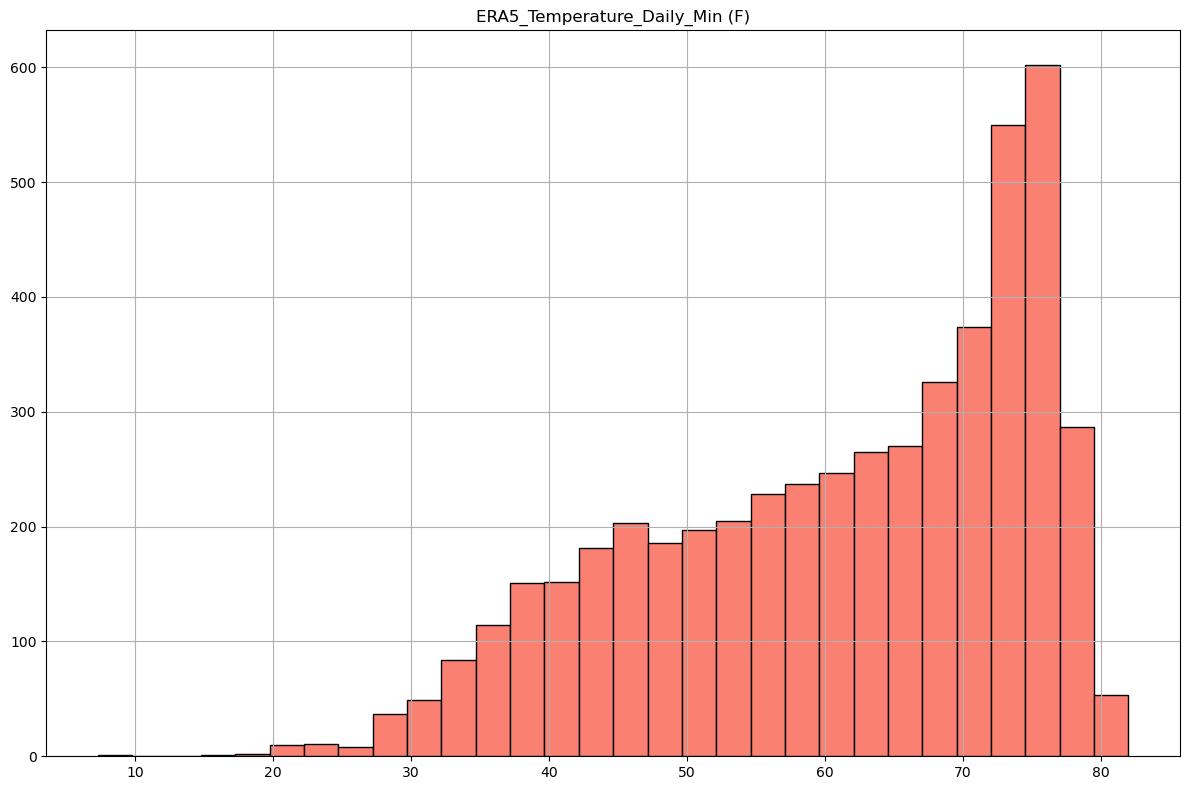

In [63]:
fig = df_FINAL.hist(
    'ERA5_Temperature_Daily_Min (F)', edgecolor='k', facecolor='salmon', bins=30, figsize=(12,8))
plt.tight_layout()
plt.show()

## save csv file

In [64]:
df_FINAL.to_csv('/glade/scratch/molina/NOAA_HOU_ERA5_SkinTemperature_2008-2022.csv')

In [65]:
df_FINAL.isnull().sum()

NOAA_HOU_Temperature_Daily_Max (C)                              224
NOAA_HOU_Temperature_Daily_Max (F)                              224
NOAA_HOU_Temperature_Daily_Max_Datetime                         224
NOAA_HOU_Temperature_Daily_Min (C)                              224
NOAA_HOU_Temperature_Daily_Min (F)                              224
NOAA_HOU_Temperature_Daily_Min_Datetime                         224
ERA5_Temperature_Daily_Max (C)                                    0
ERA5_Temperature_Daily_Max (F)                                    0
ERA5_Temperature_Daily_Max_Datetime                               0
ERA5_Temperature_Daily_Min (C)                                    0
ERA5_Temperature_Daily_Min (F)                                    0
ERA5_Temperature_Daily_Min_Datetime                               0
ERA5_Corresponding_Temperature_During_NOAA_HOU_Daily_Max (C)    224
ERA5_Corresponding_Temperature_During_NOAA_HOU_Daily_Max (F)    224
ERA5_Corresponding_Temperature_During_NOAA_HOU_D

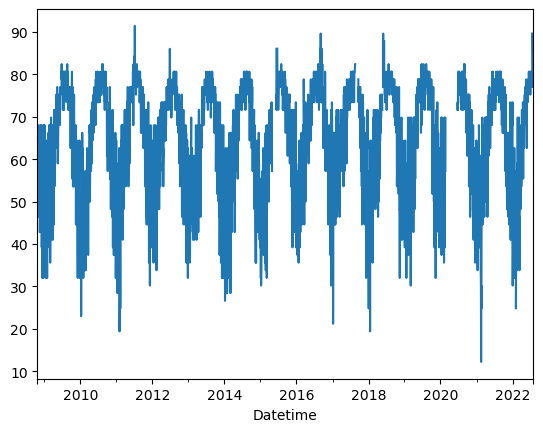

In [66]:
df_FINAL['NOAA_HOU_Temperature_Daily_Min (F)'].plot()

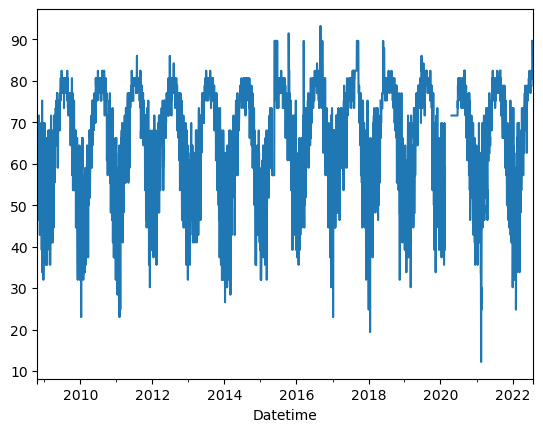

In [67]:
df_FINAL['NOAA_HOU_Corresponding_Temperature_During_ERA5_Daily_Min (F)'].plot()

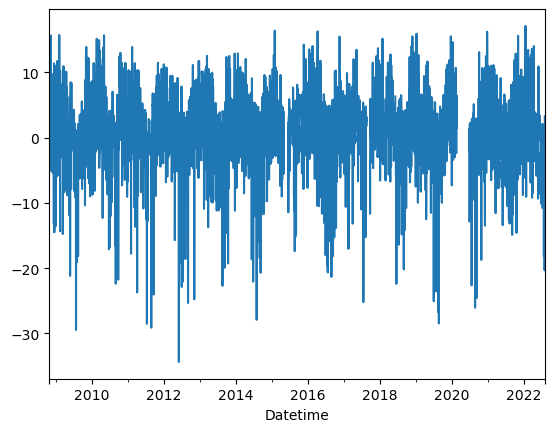

In [68]:
df_FINAL['Daily_Temperature_Min_Difference (F)'].plot()